In [216]:
import numpy as np
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import euclidean
from sklearn.feature_selection import f_regression
from statsmodels.tsa.stattools import adfuller
from sklearn.manifold import TSNE
from DBCV import DBCV
import hdbscan
import csv
import multiprocessing
import itertools
import operator
import math
from dtaidistance import dtw
import seaborn as sns
import elevation
import json
plt.style.use('fivethirtyeight')
from osgeo import gdal 
from subprocess import Popen
import simplekml
import copy
from sklearn.cluster import DBSCAN
import numpy.ma as ma
from numpy import linalg as LA

In [321]:
class Data():
    
    def __init__(self, data_path, filename1, filename2, pc=0.3):
        self.load(data_path, filename1, filename2, pc)
        
    def set_latitudes(self, latitudes):
        self.latitudes = latitudes
        
    def set_longitudes(self, longitudes):
        self.longitudes = longitudes
        
    def set_topo(self, topo):
        self.topo = topo
        
    def set_ns_mean_velocities(self, velocities):
        self.ns_mean_velocities = velocities
        
    def set_ew_mean_velocities(self, velocities):
        self.ew_mean_velocities = velocities
    
    def set_dates(self, dates):
        self.dates = dates
    
    def set_ns_displacements(self, ns_displacements):
        self.ns_displacements = ns_displacements
        
    def set_ew_displacements(self, ew_displacements):
        self.ew_displacements = ew_displacements
        
    def load(self,  data_path, filename1, filename2, pc):
        ns_displacements, ew_displacements, booleans = [], [], []
        ns_infos, ns = self.load_component(data_path, filename1)
        ew_infos, ew = self.load_component(data_path, filename2)
        m = len(ns[0])
        
        for n, components in enumerate(zip(ns, ew)):
            if ns[n].isnull().sum().sum() / m < pc:
                ns_displacements.append(components[0].interpolate(limit_direction='both', inplace=False)['displacement'].values)
                ew_displacements.append(components[1].interpolate(limit_direction='both', inplace=False)['displacement'].values)
                booleans.append(False)
            else:
                booleans.append(True)
            
        self.set_latitudes(ma.array(ns_infos['Lat'].values, mask = booleans).compressed())
        self.set_longitudes(ma.array(ns_infos['Lon'].values, mask = booleans).compressed())
        self.set_topo(ma.array(ns_infos['Topo'].values, mask = booleans).compressed())
        self.set_ns_mean_velocities(ma.array(ns_infos['Vel'].values, mask = booleans).compressed())
        self.set_ew_mean_velocities(ma.array(ew_infos['Vel'].values, mask = booleans).compressed())
        self.set_ns_displacements(np.array(ns_displacements))
        self.set_ew_displacements(np.array(ew_displacements))
        self.set_dates(ns[0].index)
        
    #np.count_nonzero(np.isnan(data))
    def load_image_correlation(self, data_path, ns_fi, ew_filename):
        df_ns, df_ns_ts = self.load_component(data_path, ns_filename)
        df_ew, df_ew_ts = self.load_component(data_path, ew_filename)
        df_ew.rename(columns={'Vel': 'Vel_ew'}, inplace=True)
        df_ns.rename(columns={'Vel': 'Vel_ns'}, inplace=True)
        geo = pd.concat([df_ew[['id', 'Lat','Lon','Topo','Vel_ew']], df_ns[['Vel_ns']]], axis=1)
        return geo, df_ns_ts, df_ew_ts
        
    def load_component(self, data_path, filename):
        
        # numéro de la ligne ou commence les données
        num_start = 44
        # numéro de la ligne ou se trouve la liste des dates
        num_list_dates = 40
        # attributs présent dans les données
        columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
        # dictionnaire stockant les données
        data = {column: [] for column in columns}
        # liste des dates 
        indexes = []
        # series temporelles
        series = []
        # liste de dataframes
        df_series = []
        
        with open(data_path + '/' + filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=",")
            line_count = 1 
            for row in csv_reader:
                if line_count == num_list_dates:
                    indexes = [row[0].split(' ')[1]] + row[1:]
                if line_count >= num_start:
                    # extraction des premiers attributs
                    for i in range(len(columns)):
                        data[columns[i]].append(row[i])
                    # extraction de l'attribut TS(série temporelle)
                    series.append([float(v) for v in row[len(columns):]])
                line_count  += 1
            if len(indexes) != len(series[0]):
                print('Erreur : Les indexes et les valeurs ne correspondent pas')
            # convertir les index en date
            indexes = [d.strip()[0:8] for d in indexes]
            # créer une liste de dataframes, chacun contenant une série temporelle
            for serie in series:
                tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
                tmp_serie.sort_index(inplace=True)
                df_series.append(tmp_serie)
            # creer un dataframe pour les autres attributs
            df = pd.DataFrame(data)
            for column in df.columns:
                df[column] = pd.to_numeric(df[column], errors='coerce')
            df.set_index('id')
            
        return df, df_series

In [218]:
class Displacement():
    def __init__(self):
        pass
    
    def compute_velocity(self, displacement):
        return 0
    
    def test(self):
        return 0
    
    def is_mean_velocity_significant(self, displacements, days):
        # extraire X et y
        X = StandardScaler().fit_transform(displacements)
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X, days)
        return  pval[0]
    
    def compute_inst_vel(self, displacements, dates):
        diff_displacements, durations = self.prepare(displacements, dates)
        return np.divide(diff_displacements, durations)
    
    # TODO
    def is_stationary(self, displacement, alpha, freq='D'):
        resampled = displacement.resample(freq)
        interpolated = upsampled.interpolate(method='linear')
        return self.compute_adfuller(interpolated) < alpha
    
     # TODO
    def smooth(self, displacement, factor):
        std = math.sqrt(serie.var())
        for i in range(len(serie)):
            if abs(serie.iloc[i].displacement) > ampl*std:
                serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
        return serie.interpolate(limit_direction='both', inplace=False)
    
    def prepare(self, displacement, dates):
        durations = np.diff(dates) / np.timedelta64(1,'D')
        return self.transform_displacement(displacement), self.transform_date(dates)
    
    def transform_date(self, dates):
        temp = np.diff(np.array(dates))
        shifted = np.array([np.timedelta64(1, 'D') for n in range(temp.shape[0])])
        shifted[0:-1] = temp[1:]
        return (shifted + temp)[:-1] / np.timedelta64(1,'D')
    
    def transform_displacement(self, displacement):
        temp = np.diff(np.array(displacement))
        shifted = np.zeros(temp.shape[0])
        shifted[0:-1] = temp[1:]
        return np.add(temp, shifted)[:-1]
    
    def transform_dates_for_lnreg(self, dates):
        lnr_dates = np.cumsum( np.diff(data.dates) /  np.timedelta64(1,'D') )
        return np.insert(lnr_dates, 0, 0, axis=0)

In [341]:
class DataFromImageCorrelation():
    
    def __init__(self, data, raster_folder_name, dem_filename, pc=0.4, alpha=0.05, ref='wgs84'):
        self.data  = data
        self.compute_slope_map(raster_folder_name, dem_filename)
        self.compute_vlm_std()
        self.n_cores = multiprocessing.cpu_count()
        self.pc = pc
        self.ref = ref
        self.alpha = alpha
        self.velocities = []
        self.mask = np.array([])
    
    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def is_ns_mean_velocity_significant(self, n):
        displacement = self.data.ns_displacements[n].reshape(-1, 1)
        dates = Displacement().transform_dates_for_lnreg(self.data.dates)
        return Displacement().is_mean_velocity_significant(displacement, dates) < self.alpha
    
    def is_ew_mean_velocity_significant(self, n):
        displacement = self.data.ew_displacements[n].reshape(-1, 1)
        dates = Displacement().transform_dates_for_lnreg(self.data.dates)
        return Displacement().is_mean_velocity_significant(displacement, dates) < self.alpha
    
    def is_mean_velocity_significant(self, n):
        return self.is_ns_mean_velocity_significant(n) and self.is_ew_mean_velocity_significant(n)
    
    def is_moving(self, n, factor):
        ns_vel = data.ns_mean_velocities[n]
        ew_vel = data.ew_mean_velocities[n]
        return self.compute_vel(ns_vel, ew_vel) > factor * self.sigma
    
    def filter_by(self, factor, min_slope=5):
        vfunc = np.vectorize(self.is_to_select)
        self.mask = vfunc(np.arange(self.data.latitudes.shape[0]), factor, min_slope)

    def is_to_select(self, n, factor, min_slope):
        return (self.is_moving(n, factor) and
               self.is_ns_mean_velocity_significant(n) and
                self.is_ew_mean_velocity_significant(n))
    
    def filter_by_linear_reg(self):
        pass
                
    def compute_vlm_std(self):
        vfunc = np.vectorize(self.compute_vel)
        ns_velocities = self.data.ns_mean_velocities
        ew_velocities = self.data.ew_mean_velocities
        self.sigma = np.std(vfunc(ns_velocities, ew_velocities))
        
    def compute_inst_vels(self, series):
        with multiprocessing.Pool(self.n_cores) as p:
            results = p.map(Displacement().compute_inst_vel, series)
            return results
        
    def compute_velocities(self):
        if self.mask.shape[0] > 0:
            ns_displacements = self.data.ns_displacements[~np.array(self.mask)]
            ew_displacements = self.data.ew_displacements[~np.array(self.mask)]
            ns_vels = self.compute_inst_vels(ns_displacements)
            ew_vels = self.compute_inst_vels(ew_displacements)
            vfunc = np.vectorize(self.compute_vel)
            self.velocities = np.array([vfunc(ns, ew) for ns, ew in zip(ns_displacements, ew_displacements)])
                    
    def set_slope_map_path(self, slope_map_path):
        self.slope_map_path = slope_map_path
        
    def load_raster(self, raster_folder_name, raster_filename):
        return gdal.Open(raster_folder_name + '/' +  raster_filename)
        
    def compute_slope_map(self, raster_folder_name, dem_name):
        dem = None
        slope_map = None
        slope_map_name = dem_name.split('.')[0] + '_' + 'slope_map.tif'
        slope_map_path = raster_folder_name + '/' + slope_map_name
        if not os.path.isfile(slope_map_path):
            dem = gdal.Open(raster_folder_name + '/'+ dem_name)
            slope_map = gdal.DEMProcessing(slope_map_path, dem, 'slope', computeEdges = True)
        self.set_slope_map_path(slope_map_path)

# Application

## Chargement des données

In [220]:
DATA_PATH = './donnees' 
filename1  = 'MM_TIO_NS_31TGK_20151227_to_20200906.csv'
filename2  = 'MM_TIO_EW_31TGK_20151227_to_20200906.csv'

In [221]:
data = Data(DATA_PATH, filename1, filename2)

## Calcul des profils de vitesse

In [281]:
raster_folder_path = 'rasters'
dem_filename =  '31TGK_copernicus_dem.tif'

In [342]:
img_correlation = DataFromImageCorrelation(data, raster_folder_path, dem_filename)

In [294]:
img_correlation.sigma

0.0015833768879708388

In [343]:
img_correlation.filter_by(factor=3)

In [304]:
img_correlation.sigma

0.0015833768879708388

In [344]:
img_correlation.compute_velocities()

TypeError: compute_inst_vel() missing 1 required positional argument: 'dates'

In [340]:
x = np.array([[1,2],[2,3],[3,4]])
mask = [False,False,True]
x[~np.array(mask)]

array([[1, 2],
       [2, 3]])

In [338]:
data.ns_displacements

array([[ 0.    , -1.4829, -1.1083, ..., -1.6207, -0.747 , -1.7681],
       [ 0.    , -1.5048, -1.135 , ..., -1.6455, -0.7691, -1.8022],
       [ 0.    , -1.471 , -1.1931, ..., -1.7787, -0.8391, -1.9032],
       ...,
       [ 0.    , -0.4363,  2.7005, ..., -3.4003,  4.2267, -3.3809],
       [ 0.    , -0.4398,  2.6997, ..., -3.4046,  4.2232, -3.3834],
       [ 0.    , -0.4432,  2.6989, ..., -3.4085,  4.2196, -3.3856]])

## Analyse en composantes princpales(PCA) et décomposition en composantes indépendantes (ICA)

In [22]:
from sklearn.decomposition import PCA, FastICA

In [89]:
data.ns_displacements.shape

(87016, 87)

In [58]:
n_components = 20
pca = PCA(n_components=n_components, random_state=0)
ica = FastICA(n_components=n_components, random_state=0)
pca_sources = pca.fit_transform(StandardScaler().fit_transform(data.ns_displacements))
ica_sources = ica.fit_transform(data.ns_displacements)

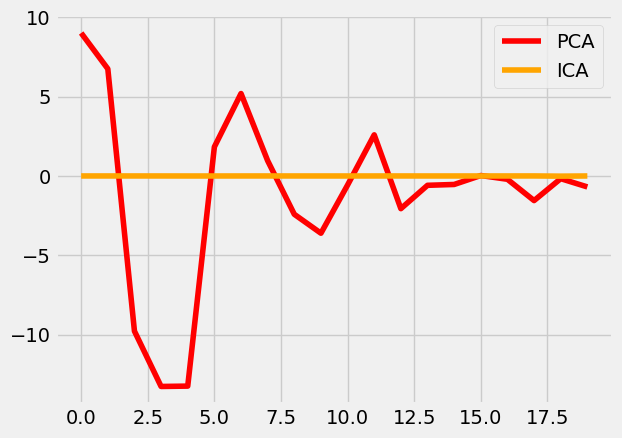

In [193]:
n = 86000
plt.plot(pc_sources[n,:], color='red', label='PCA')
plt.plot(ica_sources[n,:], color='orange', label='ICA')
plt.legend(loc='best')
plt.show()